<a href="https://colab.research.google.com/github/shreya0505/BTP_7thSem/blob/main/DOG_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Auto-Encoder

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import plot_model

import numpy as np
import os
from glob import glob
import PIL
from PIL import Image
import zipfile
import random
import matplotlib.pyplot as plt

from shutil import copyfile

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint 

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2021-11-25 11:09:06--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.75.164.142, 2600:1417:76:49f::e59, 2600:1417:76:495::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.75.164.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   115MB/s    in 6.9s    

2021-11-25 11:09:14 (114 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [45]:
SOURCE_DIR = "/tmp/PetImages/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
DOGS_DIR = "/tmp/dataset/dog/dog_images"
DOGS_PARENT_DIR = "/tmp/dataset/dog"
WEIGHTS_DOG_DIR = "/tmp/weights"

MODEL_DIR = "/tmp/models"

In [46]:
if not os.path.exists(WEIGHTS_DOG_DIR):
  os.makedirs(WEIGHTS_DOG_DIR)
  

In [6]:
print('There are',len(os.listdir(DOG_SOURCE_DIR)), 'dog images.')
# Expected Output:
# There are 12501 dog images.

There are 12501 dog images.


In [49]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 128
Z_DIM = 200 # Dimension of the latent vector (z)
LEARNING_RATE = 0.0005
N_EPOCHS = 20

# **FUNCTIONS**

In [8]:
def random_crop(LIMIT,SOURCE,DESTINATION):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + "/" + filename
        file_details = os.path.splitext(filename)
        this_file = SOURCE + filename
        if os.path.getsize(file) > 0:
          if file_details[1]=='.jpg':
            files.append(this_file)
        else:
            print(filename + " is zero length, so ignoring.")

    for i in range(LIMIT):
      img = Image.open(files[i%len(files)])
      if img.mode == 'CMYK':
        img = img.convert('RGB')
      img = img.resize(( 100,int(img.size[1]/(img.size[0]/100) )), Image.ANTIALIAS)
      w = img.size[0]; h = img.size[1]; a=0; b=0
      if w>64: a = np.random.randint(0,w-64)
      if h>64: b = np.random.randint(0,h-64)
      img = img.crop((a, b, 64+a, 64+b))
      this_file = DESTINATION + "/" + str(i)+ '.png'
      img.save(DESTINATION + "/" + str(i)+ '.png')
      if i%100000==0: print('created',i,'cropped images')
    print('created', LIMIT, 'cropped images')

In [29]:
def transfer_data(SOURCE, DESTINATION):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + "/" + filename
        file_details = os.path.splitext(filename)
        if os.path.getsize(file) > 0:
          if file_details[1]=='.jpg':
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    for filename in files:
        this_file = SOURCE + "/" + filename
        destination = DESTINATION + "/" + filename
        copyfile(this_file, destination)


In [10]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

      x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

In [11]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [12]:
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

In [13]:
def plot_compare(images=None, add_noise=False, encoder=None, decoder=None, simple_autoencoder=None):
  
  if ( (images is None) or (encoder is None) or (decoder is None) or (simple_autoencoder is None)):
    print("Invalid Inputs")
    raise ValueError

  n_to_show = images.shape[0]

  if add_noise:
    encodings = encoder.predict(images)
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = decoder.predict(encodings)

  else:
    reconst_images = simple_autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

In [14]:
 def generate_images_from_noise(n_to_show = 10, decoder=None):
  if decoder is None:
    print("Invalid Decoder")
    raise ValueError

  reconst_images = decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

# **DOG AUTOENCODER**

In [15]:
try:
    os.mkdir('/tmp/dataset')
    os.mkdir('/tmp/dataset/dog')
    os.mkdir('/tmp/dataset/dog/dog_images')
except OSError:
    pass

In [30]:
transfer_data(DOG_SOURCE_DIR, DOGS_DIR )

11702.jpg is zero length, so ignoring.


In [31]:
IMAGES = os.listdir(DOGS_DIR)
print('There are',len(IMAGES),'images. Here are 5 example filesnames:')
print(IMAGES[:5])

There are 12499 images. Here are 5 example filesnames:
['7184.jpg', '9937.jpg', '10679.jpg', '11116.jpg', '5259.jpg']


In [32]:
NUM_IMAGES_DOGS = len(os.listdir(DOGS_DIR))
print(NUM_IMAGES_DOGS,DOGS_DIR)

12499 /tmp/dataset/dog/dog_images


In [47]:
data_flow_dogs = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(DOGS_PARENT_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = BATCH_SIZE,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)

Found 12499 images belonging to 1 classes.


In [48]:
encoder_input, encoder_output,  shape_before_flattening, dog_encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

dog_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

In [37]:
decoder_input, decoder_output, dog_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
dog_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 4096)              823296    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 16, 16, 64)       36928     
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 32, 32, 64)       36928     
 pose)                                                     

In [38]:
# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = dog_decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
dog_simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

dog_simple_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0   

In [50]:
dog_optimizer = Adam(learning_rate = LEARNING_RATE)
dog_simple_autoencoder.compile(optimizer=dog_optimizer, loss = r_loss)
dog_checkpoint_ae = ModelCheckpoint(WEIGHTS_DOG_DIR, save_weights_only = True, verbose=1)

In [51]:
dog_history = dog_simple_autoencoder.fit(data_flow_dogs, 
                                 shuffle=True, 
                                 epochs = N_EPOCHS, 
                                 initial_epoch = 0, 
                                 steps_per_epoch= NUM_IMAGES_DOGS / BATCH_SIZE,
                                 callbacks=[dog_checkpoint_ae])

Epoch 1/20
50/97 [==============>...............] - ETA: 2:06 - loss: 0.0610

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

98/97 [==============================] - ETA: 0s - loss: 0.0482
Epoch 00001: saving model to /tmp/weights
97/97 [==============================] - 301s 3s/step - loss: 0.0482
Epoch 2/20
98/97 [==============================] - ETA: 0s - loss: 0.0204
Epoch 00002: saving model to /tmp/weights
97/97 [==============================] - 258s 3s/step - loss: 0.0204
Epoch 3/20
98/97 [==============================] - ETA: 0s - loss: 0.0165
Epoch 00003: saving model to /tmp/weights
97/97 [==============================] - 259s 3s/step - loss: 0.0165
Epoch 4/20
98/97 [==============================] - ETA: 0s - loss: 0.0149
Epoch 00004: saving model to /tmp/weights
97/97 [==============================] - 257s 3s/step - loss: 0.0149
Epoch 5/20
98/97 [==============================] - ETA: 0s - loss: 0.0140
Epoch 00005: saving model to /tmp/weights
97/97 [==============================] - 259s 3s/step - loss: 0.0140
Epoch 6/20
98/97 [==============================] - ETA: 0s - loss: 0.0134
Epoch 

In [54]:
dog_simple_autoencoder.save(os.path.join(MODEL_DIR, 'AE/dog.h5')) 

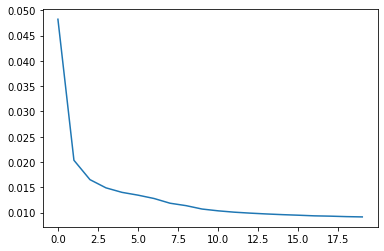

In [52]:
# Plotting loss value decrease
plt.plot(dog_history.history['loss'])

In [55]:
example_batch = next(data_flow_dogs)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [56]:
example_images.shape

(10, 128, 128, 3)

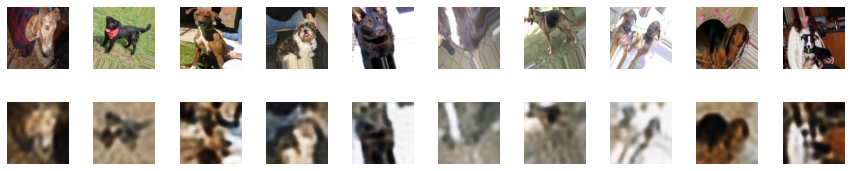

In [57]:
plot_compare(example_images, False, dog_encoder, dog_decoder, dog_simple_autoencoder)

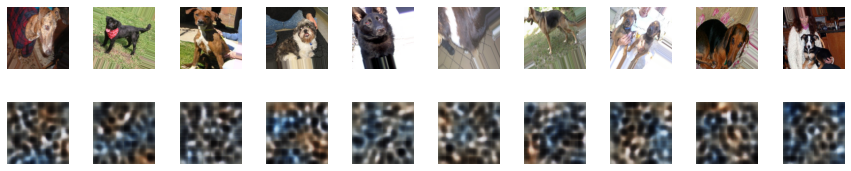

In [58]:
plot_compare(example_images, True, dog_encoder, dog_decoder, dog_simple_autoencoder)

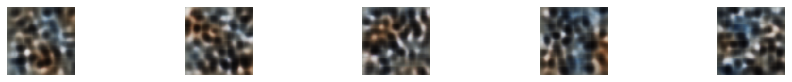

In [59]:
generate_images_from_noise(5, dog_decoder)

# **CAT AUTOENCODER**